In [346]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from lmfit.models import LinearModel, LorentzianModel
from uncertainties import unumpy as up
from uncertainties import ufloat
from uncertainties import wrap
import uncertainties as uc
from pathlib import Path

In [347]:
def voigt1(x,s1,g1,o1,scale1):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)
def voigt2(x,s1,s2,g1,g2,o1,o2,scale1,scale2):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)+scale2*scipy.special.voigt_profile(x-o2,s2,g2)

In [348]:
def FWHM(s_p,g_p):
    s = ufloat(s_p.value,s_p.stderr)
    g = ufloat(g_p.value,g_p.stderr)
    fg=s*(8*up.log(2))**0.5
    fl=2*g
    return 0.5346*fl+((fg)**2+(0.2166*fl**2))**0.5

def uvoigt1(out_voigt):
    x_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x = ufloat(x_p.value,x_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    uv=wrap(voigt1)
    return uv(x,s1,g1,o1,scale1)

def uvoigt2(out_voigt):
    x1_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x2_p,s2_p,g2_p,o2_p,scale2_p=out_voigt.result.params['o2'],out_voigt.result.params['s2'],out_voigt.result.params['g2'],out_voigt.result.params['o2'],out_voigt.result.params['scale2']
    x1 = ufloat(x1_p.value,x1_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    x2 = ufloat(x2_p.value,x2_p.stderr)
    s2 = ufloat(s2_p.value,s2_p.stderr)
    g2 = ufloat(g2_p.value,g2_p.stderr)
    o2 = ufloat(o2_p.value,o2_p.stderr)
    scale2 = ufloat(scale2_p.value,scale2_p.stderr)


    uv=wrap(voigt2)

    p1 = uv(x1,s1,s2,g1,g2,o1,o2,scale1,scale2)
    p2 = uv(x2,s1,s2,g1,g2,o1,o2,scale1,scale2)
    return p1,p2

def uvoigt(out_voigt):
    try:
        return uvoigt2(out_voigt)
    except:
        return uvoigt1(out_voigt)

In [349]:
res = Path("results_1-4_ohne/voigt_fits_30_15_ohne.txt")
res.touch()
nf = open(res,"w")
nf.write("Amplitude1\tAmplitude2\tmu1\tmu2\tsigma1\tsigma2\tgamma1\tgamma2\tFWHM1\tFWHM2\tHeight1\tHeight2\tredchi\n")

def bwrite(fr,fwhm1,height1):
    nf.write(
                str(fr.params['scale1'].value)+"\t"+str(fr.params['scale1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['o1'].value)+"\t"+str(fr.params['o1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['s1'].value)+"\t"+str(fr.params['s1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['g1'].value)+"\t"+str(fr.params['g1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fwhm1[0])+"\t"+str(fwhm1[1])+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(height1[0])+"\t"+str(height1[1])+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.redchi)+"\n"
                )
        

def awrite(fr,fwhm1,height1,fwhm2,height2):
    nf.write(
                str(fr.params['scale1'].value)+"\t"+str(fr.params['scale1'].stderr)+"\t"+
                str(fr.params['scale2'].value)+"\t"+str(fr.params['scale2'].stderr)+"\t"+                
                str(fr.params['o1'].value)+"\t"+str(fr.params['o1'].stderr)+"\t"+
                str(fr.params['o2'].value)+"\t"+str(fr.params['o2'].stderr)+"\t"+                
                str(fr.params['s1'].value)+"\t"+str(fr.params['s1'].stderr)+"\t"+
                str(fr.params['s2'].value)+"\t"+str(fr.params['s2'].stderr)+"\t"+                
                str(fr.params['g1'].value)+"\t"+str(fr.params['g1'].stderr)+"\t"+
                str(fr.params['g2'].value)+"\t"+str(fr.params['g2'].stderr)+"\t"+                
                str(fwhm1[0])+"\t"+str(fwhm1[1])+"\t"+
                str(fwhm2[0])+"\t"+str(fwhm2[1])+"\t"+                
                str(height1[0])+"\t"+str(height1[1])+"\t"+
                str(height2[0])+"\t"+str(height2[1])+"\t"+                
                str(fr.redchi)+"\n"
                )
       

In [350]:
path =  'Data/SI_111_30_15.xy'
with open(path) as tf:
    data = np.loadtxt(tf,delimiter=" ").T

err = np.zeros(len(data[1]))
for i in range(len(err)):
    err[i] = (data[1,i])**0.5
data = np.vstack([data,err])

zu betrachtende intervalle:  
b1[25,26]->[667,733]  
a1[28,29]->[867,933]  
b2[52.4,53]->[2493,2533]  
a2[58.5,59.25]->[2900,2950]  
b3[83,84]->[4533,4600]  
a3[93,97]->[5200,5467]  5300:5367

In [351]:
for i in range(len(data[0])):
    if data[0,i]>=95.5:
        print(i)
        break

5367


In [352]:
#modell erstellen b1[25,26]->[667,733] 
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["o1"].set(value=25.6,min=25.5,max=25.75)
pars_voigt["scale1"].set(7000)

#Fitten
out_voigt = model_voigt.fit(data[1,667:733],x=data[0,667:733],params=pars_voigt,weights=1/data[2,667:733],nan_policy='propagate')
b1f=out_voigt.fit_report()
b1p=np.array([np.arange(25,26,0.001),out_voigt.eval(x=np.arange(25,26,0.001))])



h1 = uvoigt(out_voigt).format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)

In [353]:
#modell erstellen a1[28,29]->[867,933]  
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=28.4,min=28,max=29)
pars_voigt["o2"].set(value=28.5,min=28,max=29)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,867:933],x=data[0,867:933],params=pars_voigt,weights=1/data[2,867:933],nan_policy='propagate')
a1f=out_voigt.fit_report()
a1p=np.array([np.arange(28,29,0.001),out_voigt.eval(x=np.arange(28,29,0.001))])


h1 = uvoigt(out_voigt)[0].format(":1.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":1.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)


In [354]:
#modell erstellen b2[52.4,53]->[2493,2533] 
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value= 0.7,min=0.01,max=1)
pars_voigt["g1"].set(value=0.0137,min=0.001,max=1)
pars_voigt["o1"].set(value=52.67,min=52.4,max=53)
pars_voigt["scale1"].set(100)

#Fitten
out_voigt = model_voigt.fit(data[1,2493:2533],x=data[0,2493:2533],params=pars_voigt,weights=1/data[2,2493:2533],nan_policy='propagate')
b2f=out_voigt.fit_report()
b2p=np.array([np.arange(52.4,53,0.001),out_voigt.eval(x=np.arange(52.4,53,0.001))])


h1 = uvoigt(out_voigt).format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)





In [355]:
#modell erstellen a2[58.5,59.25]->[2900,2950]2900:2950
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.01,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0.01,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=58.6,min=58.5,max=59.25)
pars_voigt["o2"].set(value=59,min=58.5,max=59.25)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,2900:2950],x=data[0,2900:2950],params=pars_voigt,weights=1/data[2,2900:2950],nan_policy='propagate')
a2f=out_voigt.fit_report()
a2p=np.array([np.arange(58.5,59.25,0.001),out_voigt.eval(x=np.arange(58.5,59.25,0.001))])



h1 = uvoigt(out_voigt)[0].format(":1.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":1.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)



In [356]:
#modell erstellen b3[83,84]->[4533,4600]
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.0009,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["o1"].set(value=83.5,min=83,max=84)
pars_voigt["scale1"].set(100)

#Fitten
out_voigt = model_voigt.fit(data[1,4533:4600],x=data[0,4533:4600],params=pars_voigt,weights=1/data[2,4533:4600],nan_policy='propagate')
b3f=out_voigt.fit_report()
b3p=np.array([np.arange(83,84,0.001),out_voigt.eval(x=np.arange(83,84,0.001))])

h1 = uvoigt(out_voigt).format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)


In [357]:
#modell erstellen a3[93,97]->[5200,5467]  
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.01,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0.01,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=94.9,min=93,max=97)
pars_voigt["o2"].set(value=95.3,min=93,max=97)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,5200:5467],x=data[0,5200:5467],params=pars_voigt,weights=1/data[2,5200:5467],nan_policy='propagate')
a3f=out_voigt.fit_report()
a3p=np.array([np.arange(94.5,95.5,0.001),out_voigt.eval(x=np.arange(94.5,95.5,0.001))])


h1 = uvoigt(out_voigt)[0].format(":1.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":1.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)


nf.close()

(52.0, 60.0)

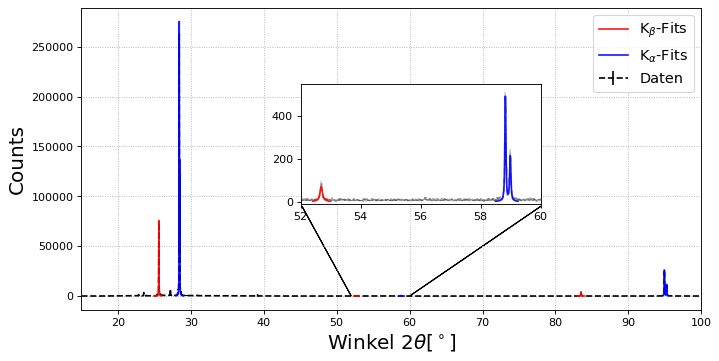

In [358]:

fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.errorbar(data[0],data[1],yerr=data[2],zorder=5,mfc='black',color='k',linestyle='--',label='Daten')
plt.plot(b1p[0],b1p[1],zorder=10,label='K'r'$_\beta$''-Fits',color='r',alpha=0.9)
plt.plot(a1p[0],a1p[1],zorder=10,label='K'r'$_\alpha$''-Fits',color='b',alpha=0.9)
plt.plot(b2p[0],b2p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a2p[0],a2p[1],zorder=10,color='b',alpha=0.9)
plt.plot(b3p[0],b3p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a3p[0],a3p[1],zorder=10,color='b',alpha=0.9)

plt.legend(fontsize=13)
plt.grid(axis='both',linestyle=':')
plt.xlim(15,100)
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.arrow(45.25,90000,6.75,-90000)
plt.arrow(78,90000,-18,-90000)

# this is an inset axes over the main axes
a = plt.axes([.399, .39, .3, .3])
plt.plot(b2p[0],b2p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a2p[0],a2p[1],zorder=10,color='b',alpha=0.9)
plt.errorbar(data[0],data[1],yerr=data[2],zorder=5,mfc='black',color='k',linestyle='--',alpha=0.2)
plt.ylim(-10,550)
plt.xlim(52,60)
#plt.savefig('plots_1-4_ohne/hauptplots/spek_30_15_ohne.pdf')

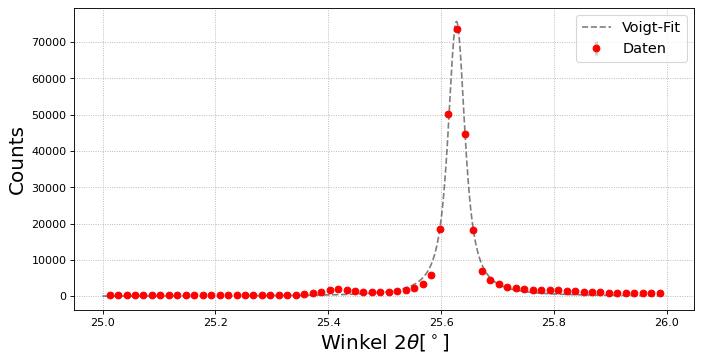

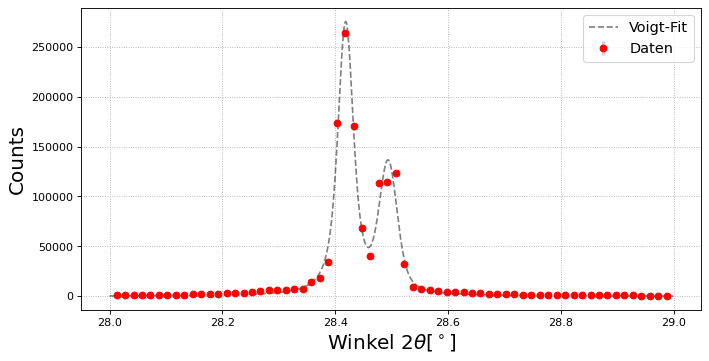

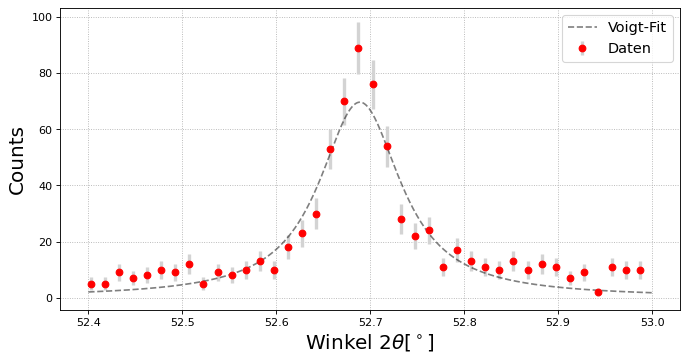

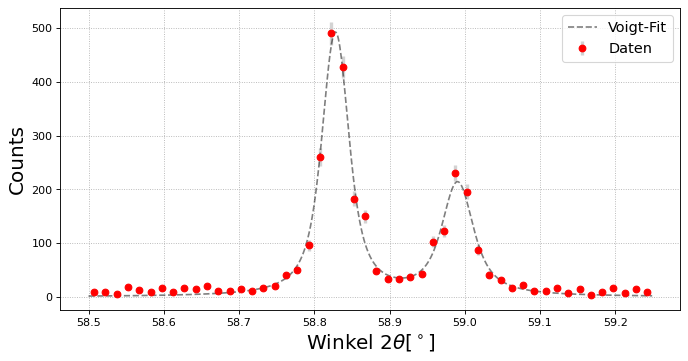

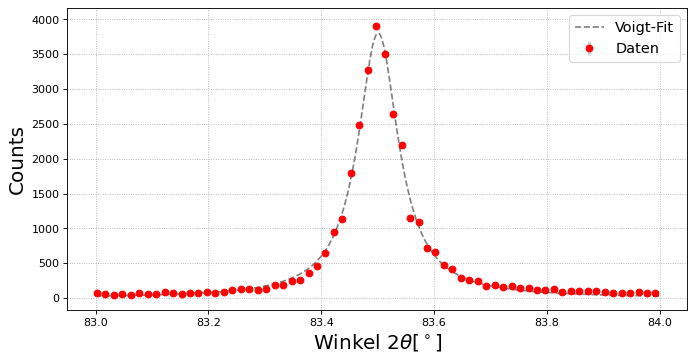

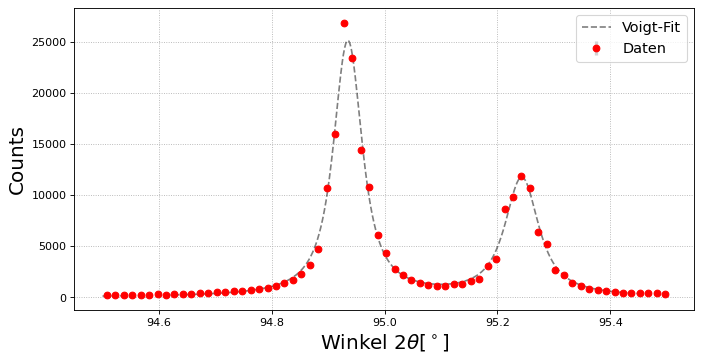

In [359]:
#plt.style.use('fivethirtyeight') #plt.savefig('plots_1-4_ohne/voigt_fit_30_15_ohne/.png')

fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,667:733],data[1,667:733],yerr=data[2,667:733],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b1p[0],b1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fit_30_15_ohne/b1.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,867:933],data[1,867:933],yerr=data[2,867:933],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a1p[0],a1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fit_30_15_ohne/a1.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,2493:2533],data[1,2493:2533],yerr=data[2,2493:2533],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b2p[0],b2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fit_30_15_ohne/b2.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,2900:2950],data[1,2900:2950],yerr=data[2,2900:2950],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a2p[0],a2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fit_30_15_ohne/a2.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,4533:4600],data[1,4533:4600],yerr=data[2,4533:4600],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b3p[0],b3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fit_30_15_ohne/b3.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,5300:5367],data[1,5300:5367],yerr=data[2,5300:5367],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a3p[0],a3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fit_30_15_ohne/a3.pdf')

In [360]:
print('b1#######################################')
print(b1f)
print('a1#######################################')
print(a1f)
print('b2#######################################')
print(b2f)
print('a2#######################################')
print(a2f)
print('b3#######################################')
print(b3f)
print('a3#######################################')
print(a3f)



b1#######################################
[[Model]]
    Model(voigt1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 66
    # variables        = 4
    chi-square         = 21386.1738
    reduced chi-square = 344.938288
    Akaike info crit   = 389.535781
    Bayesian info crit = 398.294400
[[Variables]]
    s1:      0.00624652 +/- 0.00247458 (39.62%) (init = 0.0137)
    g1:      0.01466611 +/- 0.00126542 (8.63%) (init = 0.0137)
    o1:      25.6274008 +/- 8.5134e-04 (0.00%) (init = 25.6)
    scale1:  3988.71883 +/- 145.258097 (3.64%) (init = 7000)
[[Correlations]] (unreported correlations are < 0.100)
    C(s1, g1) = -0.756
a1#######################################
[[Model]]
    Model(voigt2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 208
    # data points      = 66
    # variables        = 8
    chi-square         = 63949.7111
    reduced chi-square = 1102.58123
    Akaike info crit   = 469.829